In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import Series, DataFrame
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import linkage, fcluster 

from functions import *

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
# Import the data set
df = pd.read_csv('Necessary Insurance DB.csv')

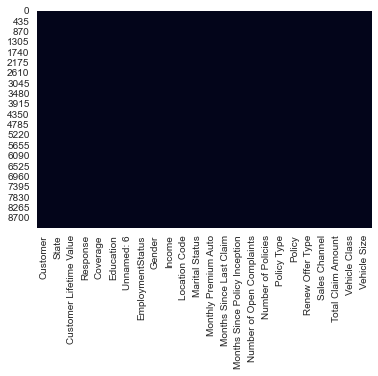

In [3]:
sns.heatmap(df.isnull() | df.isna(), cbar=False)

In [4]:
df.head()

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Unnamed: 6,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,"$2,764",No,Basic,Bachelor,2/24/11,Employed,F,"$56,274",Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,$385,Two-Door Car,Medsize
1,QZ44356,Arizona,"$6,980",No,Extended,Bachelor,1/31/11,Unemployed,F,$0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,"$1,131",Four-Door Car,Medsize
2,AI49188,Nevada,"$12,887",No,Premium,Bachelor,2/19/11,Employed,F,"$48,767",Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,$566,Two-Door Car,Medsize
3,WW63253,California,"$7,646",No,Basic,Bachelor,1/20/11,Unemployed,M,$0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,$530,SUV,Medsize
4,HB64268,Washington,"$2,814",No,Basic,Bachelor,11-3-02,Employed,M,"$43,836",Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,$138,Four-Door Car,Medsize


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Customer                       9134 non-null   object
 1   State                          9134 non-null   object
 2   Customer Lifetime Value        9134 non-null   object
 3   Response                       9134 non-null   object
 4   Coverage                       9134 non-null   object
 5   Education                      9134 non-null   object
 6   Unnamed: 6                     9134 non-null   object
 7   EmploymentStatus               9134 non-null   object
 8   Gender                         9134 non-null   object
 9   Income                         9134 non-null   object
 10  Location Code                  9134 non-null   object
 11  Marital Status                 9134 non-null   object
 12  Monthly Premium Auto           9134 non-null   int64 
 13  Mon

In [6]:
df.describe()

,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,93.219291,15.097000,48.064594,0.384388,2.966170
std,34.407967,10.073257,27.905991,0.910384,2.390182
min,61.000000,0.000000,0.000000,0.000000,1.000000
25%,68.000000,6.000000,24.000000,0.000000,1.000000
50%,83.000000,14.000000,48.000000,0.000000,2.000000
75%,109.000000,23.000000,71.000000,0.000000,4.000000
max,298.000000,35.000000,99.000000,5.000000,9.000000


## Pre-process

In [7]:
df.drop(['Unnamed: 6', 'Response', 'Customer'], axis=1, inplace = True)

In [8]:
for c in ['Customer Lifetime Value', 'Income', 'Total Claim Amount']:
    df[c] = df[c].replace('[\$,]', '', regex=True).astype(float)

In [9]:
for i in ['State', 'Coverage', 'Education', 'EmploymentStatus', 'Gender', 
          'Marital Status', 'Location Code', 'Policy Type', 'Policy',
         'Vehicle Class', 'Vehicle Size', 'Renew Offer Type', 'Sales Channel']:
    print(i)
    print(df[i].unique())
    print(df[i].value_counts())
    print()

State
['Washington' 'Arizona' 'Nevada' 'California' 'Oregon']
California    3150
Oregon        2601
Arizona       1703
Nevada         882
Washington     798
Name: State, dtype: int64

Coverage
['Basic' 'Extended' 'Premium']
Basic       5568
Extended    2742
Premium      824
Name: Coverage, dtype: int64

Education
['Bachelor' 'College' 'Master' 'High School or Below' 'Doctor']
Bachelor                2748
College                 2681
High School or Below    2622
Master                   741
Doctor                   342
Name: Education, dtype: int64

EmploymentStatus
['Employed' 'Unemployed' 'Medical Leave' 'Disabled' 'Retired']
Employed         5698
Unemployed       2317
Medical Leave     432
Disabled          405
Retired           282
Name: EmploymentStatus, dtype: int64

Gender
['F' 'M']
F    4658
M    4476
Name: Gender, dtype: int64

Marital Status
['Married' 'Single' 'Divorced']
Married     5298
Single      2467
Divorced    1369
Name: Marital Status, dtype: int64

Location Code
['Su

In [10]:
df['EmploymentStatus'] = df['EmploymentStatus'].apply(lambda x : 'Employed' if x == 'Employed' else 'Unemployed')

In [11]:
df['Marital Status'] = df['Marital Status'].apply(lambda x : 'Married' if x == 'Married' else 'Not Married')

In [12]:
# remove outliers
dfc = df[np.abs(df['Customer Lifetime Value'] - df['Customer Lifetime Value'].mean()) <= (2*df['Customer Lifetime Value'].std())].copy()

In [13]:
dfc = dfc[dfc['Months Since Policy Inception'] != 0] # remove those who just singed up - 4 rows
dfc = dfc[dfc['Number of Policies'] <= 3] # remove multi-vehicle policies

# remove redundant cols
dfc.drop('Number of Policies', axis=1, inplace=True)
dfc.drop('Monthly Premium Auto', axis=1, inplace=True)

# average lifetime value
dfc['Customer Lifetime Value'] = dfc['Customer Lifetime Value'] / dfc['Months Since Policy Inception']
dfc.drop('Months Since Policy Inception', axis=1, inplace=True)

In [14]:
#for c in ['Monthly Premium Auto', 'Renew Offer Type', 'Sales Channel', 'Policy', 'Vehicle Class', 'Number of Open Complaints']:
for c in ['Policy', 'Vehicle Class', 'Renew Offer Type', 'Sales Channel']:
    dfc.drop(c, axis=1, inplace=True)

In [15]:
# take care of the categorical features
cat_cols = ['Gender', 'State', 'Location Code', 'Policy Type', 'EmploymentStatus', 'Marital Status'];
for i in  cat_cols:
    dfc[i] = dfc[i].astype('category')

In [16]:
# encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

ord_cols = ['Coverage', 'Education', 'Vehicle Size']
dfc[ord_cols] = dfc[ord_cols].apply(lambda col: le.fit_transform(col))

In [17]:
# set dummy values
for i in cat_cols:
    df_dum = pd.get_dummies(dfc[i], drop_first=True)
    
    cols = []
    for c in df_dum:
        cols.append("%s%s" % (i, str(df_dum[c].name)))
    df_dum.columns = cols;
    dfc = pd.concat([dfc, df_dum],axis=1)
    dfc = dfc.drop(i, axis=1)

In [18]:
dfc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6193 entries, 0 to 9133
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Customer Lifetime Value     6193 non-null   float64
 1   Coverage                    6193 non-null   int32  
 2   Education                   6193 non-null   int32  
 3   Income                      6193 non-null   float64
 4   Months Since Last Claim     6193 non-null   int64  
 5   Number of Open Complaints   6193 non-null   int64  
 6   Total Claim Amount          6193 non-null   float64
 7   Vehicle Size                6193 non-null   int32  
 8   GenderM                     6193 non-null   uint8  
 9   StateCalifornia             6193 non-null   uint8  
 10  StateNevada                 6193 non-null   uint8  
 11  StateOregon                 6193 non-null   uint8  
 12  StateWashington             6193 non-null   uint8  
 13  Location CodeSuburban       6193 

In [19]:
dfc.head()

,Customer Lifetime Value,Coverage,Education,Income,Months Since Last Claim,Number of Open Complaints,Total Claim Amount,Vehicle Size,GenderM,StateCalifornia,StateNevada,StateOregon,StateWashington,Location CodeSuburban,Location CodeUrban,Policy TypePersonal Auto,Policy TypeSpecial Auto,EmploymentStatusUnemployed,Marital StatusNot Married
0,552.800000,0,0,56274.0,32,0,385.0,1,0,0,0,0,1,1,0,0,0,0,0
2,339.131579,2,0,48767.0,18,0,566.0,1,0,0,1,0,0,1,0,1,0,0,0
4,63.954545,0,0,43836.0,12,0,138.0,1,1,0,0,0,1,0,0,1,0,0,1
5,87.829787,0,0,62902.0,14,0,159.0,1,0,0,0,1,0,0,0,1,0,0,0
10,947.800000,0,1,0.0,23,0,482.0,2,1,1,0,0,0,1,0,1,0,1,1


In [20]:
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.945697,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.087475
std,6870.968043,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.493757
min,1898.000000,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3994.250000,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.000000
50%,5780.000000,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,384.000000
75%,8962.250000,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.750000
max,83325.000000,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.000000


In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y = dfc['Customer Lifetime Value']
dfc.drop('Customer Lifetime Value', axis = 1)
X = dfc
Xs = scaler.fit_transform(X)

## Making sense out of the data

In [22]:
from sklearn.cluster import KMeans

kmeans = KMeans(init='random', n_clusters=3, n_init=10)
kmeans.fit(Xs)
clusters =  kmeans.predict(Xs)

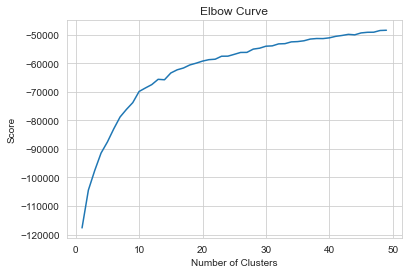

In [23]:
num_clusters = 50
kmeans_tests = [KMeans(n_clusters=i, init='random', n_init=10) for i in range(1, num_clusters)]
score = [kmeans_tests[i].fit(Xs).score(Xs) for i in range(len(kmeans_tests))]

# Plot the curve
plt.plot(range(1, num_clusters),score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [24]:
from sklearn.decomposition import PCA

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=2)
pca.fit(Xs)

# Transfor the scaled data to the new PCA space
Xreduced = pca.transform(Xs)

In [25]:
Xrdf = pd.DataFrame(Xreduced, index=X.index, columns=['PC1','PC2'])
Xrdf['cluster'] = clusters
Xrdf.head()

,PC1,PC2,cluster
0,-0.486245,-0.413855,0
2,0.125302,-0.418583,0
4,-1.098595,-0.338612,1
5,-1.890922,-1.635056,1
10,2.157780,1.472877,2


In [26]:
centres_reduced = pca.transform(kmeans.cluster_centers_)

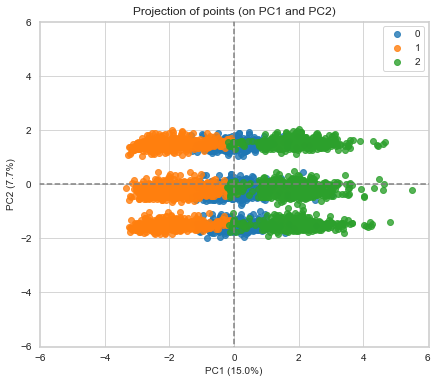

In [27]:
display_factorial_planes(Xreduced, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)

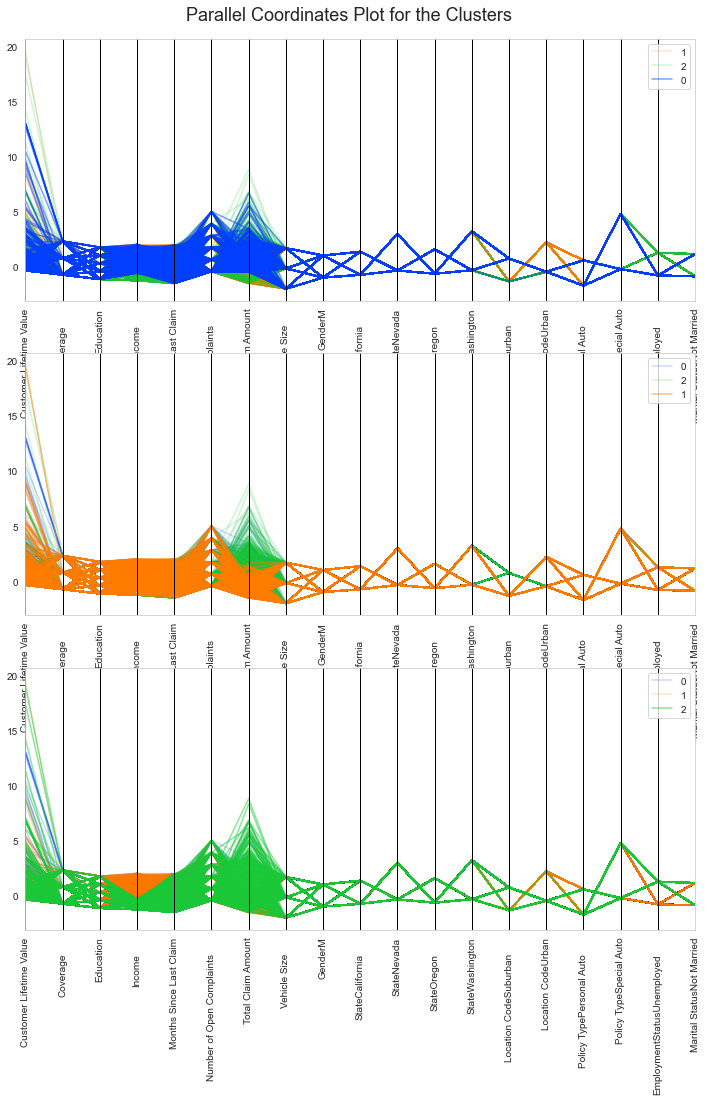

In [28]:
# Add the cluster number to the original scaled data
Xclustered = pd.DataFrame(Xs, index=X.index, columns=X.columns)
Xclustered["cluster"] = clusters

# Display parallel coordinates plots, one for each cluster
display_parallel_coordinates(Xclustered, 3)

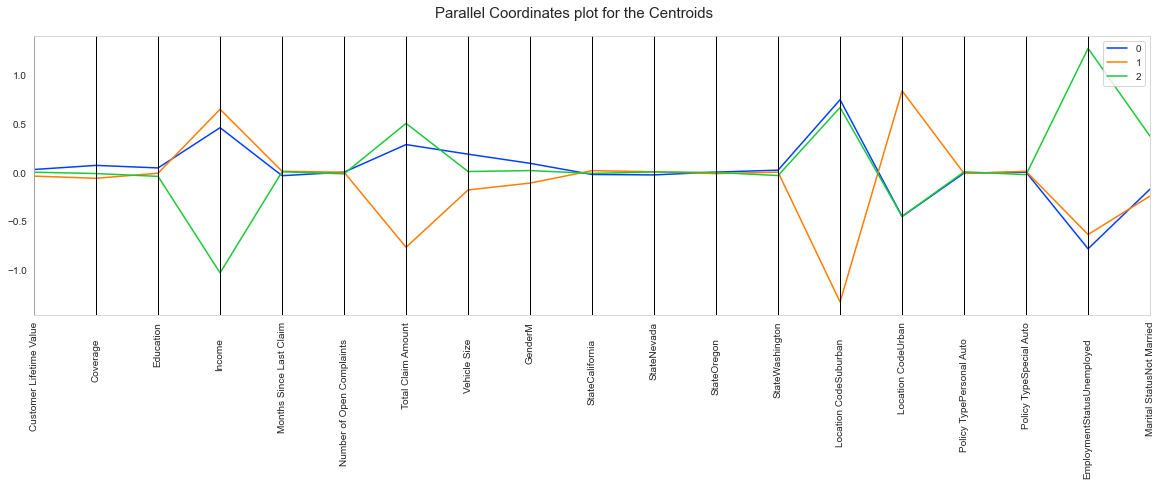

In [29]:
# Create a data frame containing our centroids
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids['cluster'] = centroids.index

display_parallel_coordinates_centroids(centroids, 10)

In [30]:

# Create a PCA model to reduce our data to 2 dimensions for visualisation
pca = PCA(n_components=len(Xs[0]))
pca.fit(Xs)

# Transfor the scaled data to the new PCA space
X_reduced = pca.transform(Xs)

In [31]:
pca.explained_variance_ratio_.cumsum().round(2)

array([0.15, 0.23, 0.3 , 0.36, 0.43, 0.49, 0.54, 0.6 , 0.65, 0.7 , 0.76,
       0.81, 0.85, 0.9 , 0.93, 0.96, 0.98, 0.99, 1.  ])

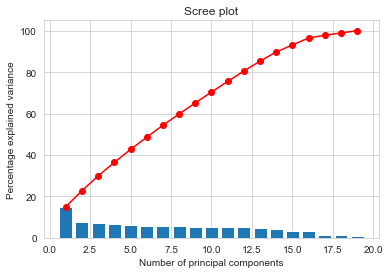

In [32]:
display_scree_plot(pca)

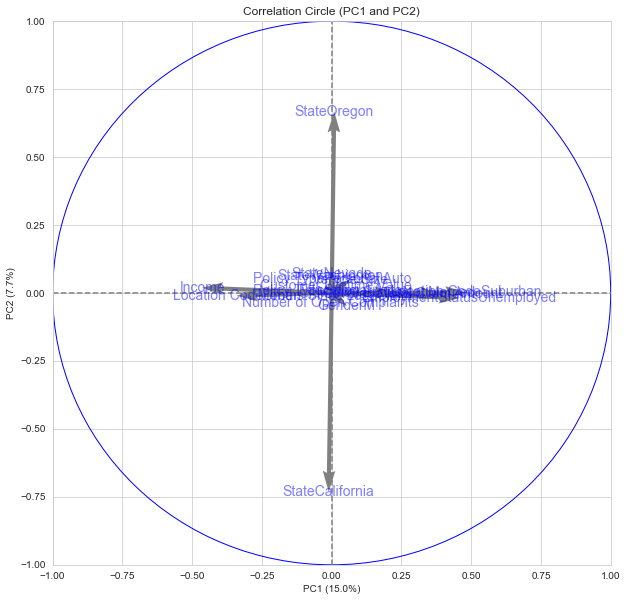

In [33]:
display_circles(pca.components_, 5, pca, [(0,1)], labels = np.array(dfc.columns),)

## 1)	Which characteristics are most useful in determining the value of the customers?

We are looking for customers that bring the most profit. Such customers include people who paid the most premiums with the fewest claims. Intuition suggest that customer gender, marital status, education, income level, employment status contribute to how much profit they bring over the lifetime.

After running PCA and looking at the scree plot, we can defintiley conclude that dimensionality reduction can not be used without a major information loss - so we need all of the information for decision making.

## 2) Which clients provide the highest lifetime value?

In [34]:
hlv = df.sort_values(by=['Customer Lifetime Value'], ascending=False).head(10)
hlv.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.0,10.000000
mean,67162.700000,23526.000000,209.700000,17.500000,46.600000,0.200000,2.0,1201.400000
std,7711.069187,28639.364848,21.013488,13.930382,23.438809,0.421637,0.0,566.614939
min,58754.000000,0.000000,185.000000,0.000000,18.000000,0.000000,2.0,152.000000
25%,61313.750000,0.000000,193.500000,4.250000,30.250000,0.000000,2.0,972.250000
50%,65322.500000,12482.000000,203.000000,16.500000,42.500000,0.000000,2.0,1125.500000
75%,71896.250000,38030.500000,227.500000,30.250000,67.000000,0.000000,2.0,1470.250000
max,83325.000000,78310.000000,242.000000,35.000000,84.000000,1.000000,2.0,2275.000000


In [35]:
df.sort_values(by=['Customer Lifetime Value'], ascending=False).head(10)

,State,Customer Lifetime Value,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
5716,Oregon,83325.0,Extended,High School or Below,Employed,M,58958.0,Suburban,Married,231,31,74,0,2,Personal Auto,Personal L3,Offer1,Call Center,1109.0,Luxury Car,Small
1974,Washington,74229.0,Extended,High School or Below,Unemployed,M,0.0,Suburban,Not Married,242,1,34,0,2,Personal Auto,Personal L1,Offer1,Branch,1742.0,Luxury Car,Medsize
6252,California,73226.0,Extended,Bachelor,Employed,F,39547.0,Suburban,Married,202,11,21,0,2,Personal Auto,Personal L3,Offer1,Branch,970.0,Luxury SUV,Medsize
7283,Oregon,67907.0,Premium,Bachelor,Employed,M,78310.0,Rural,Married,192,34,18,1,2,Personal Auto,Personal L1,Offer1,Agent,152.0,Sports Car,Medsize
5279,Washington,66026.0,Basic,Bachelor,Employed,M,33481.0,Suburban,Not Married,188,28,46,0,2,Personal Auto,Personal L3,Offer1,Agent,1195.0,Luxury SUV,Medsize
7303,California,64619.0,Extended,High School or Below,Unemployed,M,0.0,Suburban,Married,217,14,40,1,2,Personal Auto,Personal L3,Offer1,Branch,1562.0,Luxury Car,Small
3760,Oregon,61850.0,Extended,College,Unemployed,F,0.0,Suburban,Married,238,19,29,0,2,Personal Auto,Personal L1,Offer3,Branch,1142.0,Luxury SUV,Medsize
8825,California,61135.0,Basic,College,Unemployed,M,0.0,Suburban,Not Married,198,2,75,0,2,Corporate Auto,Corporate L3,Offer2,Branch,2275.0,Luxury Car,Medsize
4126,Arizona,60556.0,Extended,College,Unemployed,F,0.0,Suburban,Married,204,35,45,0,2,Personal Auto,Personal L3,Offer1,Web,979.0,Luxury SUV,Large
2908,Arizona,58754.0,Premium,Bachelor,Employed,F,24964.0,Suburban,Married,185,0,84,0,2,Personal Auto,Personal L2,Offer2,Agent,888.0,SUV,Medsize


Looking at top 20 customers with the highest lifetime value, we can say that those are the mostly well-educated suburban dwellers owning 2 policies for luxury vehicles, who've been insrued on average 46 months and own extended/premium policy

## 3)	Which clients are most likely to make a claim?

In [36]:
df[df['Number of Open Complaints'] >= 5].describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.0,56.000000,56.000000
mean,6145.750000,37835.232143,92.446429,14.482143,55.767857,5.0,3.071429,457.607143
std,4007.199109,32147.145050,39.002527,9.380814,26.608263,0.0,2.156235,306.907133
min,1899.000000,0.000000,61.000000,0.000000,6.000000,5.0,1.000000,14.000000
25%,3040.000000,0.000000,67.750000,5.750000,37.000000,5.0,1.000000,301.000000
50%,5031.500000,28578.500000,79.500000,14.000000,54.000000,5.0,2.000000,438.000000
75%,7136.000000,66273.000000,99.750000,21.250000,78.000000,5.0,5.000000,551.750000
max,20474.000000,97917.000000,253.000000,30.000000,97.000000,5.0,8.000000,1606.000000


In [37]:
df[df['Number of Open Complaints'] >= 5].head(10)

,State,Customer Lifetime Value,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
86,California,5927.0,Extended,College,Unemployed,M,23091.0,Suburban,Married,96,28,90,5,5,Personal Auto,Personal L1,Offer1,Agent,461.0,Four-Door Car,Medsize
243,California,6409.0,Extended,College,Employed,M,49988.0,Suburban,Married,84,6,37,5,5,Personal Auto,Personal L2,Offer2,Web,567.0,Two-Door Car,Large
244,California,2377.0,Extended,College,Unemployed,F,0.0,Suburban,Not Married,91,2,8,5,1,Personal Auto,Personal L1,Offer1,Agent,437.0,Two-Door Car,Medsize
403,Arizona,3538.0,Basic,College,Unemployed,F,0.0,Suburban,Not Married,67,12,67,5,7,Personal Auto,Personal L2,Offer4,Call Center,322.0,Four-Door Car,Medsize
645,Nevada,3100.0,Basic,Bachelor,Unemployed,M,0.0,Suburban,Not Married,102,18,32,5,1,Corporate Auto,Corporate L2,Offer2,Call Center,863.0,SUV,Medsize
899,California,4923.0,Basic,Bachelor,Employed,F,61469.0,Suburban,Married,63,16,65,5,3,Personal Auto,Personal L3,Offer3,Branch,302.0,Four-Door Car,Small
1113,Nevada,2390.0,Basic,College,Employed,M,58652.0,Suburban,Married,64,14,75,5,1,Personal Auto,Personal L2,Offer2,Agent,307.0,Four-Door Car,Small
1305,California,3610.0,Extended,College,Employed,M,58297.0,Suburban,Married,97,19,94,5,1,Special Auto,Special L3,Offer1,Agent,647.0,Four-Door Car,Small
1319,Washington,8177.0,Basic,Bachelor,Employed,M,67137.0,Urban,Married,111,0,49,5,6,Personal Auto,Personal L1,Offer2,Agent,315.0,SUV,Medsize
1393,Washington,5899.0,Extended,Bachelor,Employed,F,53998.0,Suburban,Not Married,78,5,38,5,8,Personal Auto,Personal L3,Offer1,Call Center,415.0,Four-Door Car,Medsize


Looking at top 10 customers with largest claims lifetime value, we can say that those are the mostly well-educated suburban dwellers owning small and midsize cars, with a large number of policies (>2) and basic or extended coverage

## 4) Which offer is most likely to attract high-value customers? Which Sales Channel?

In [38]:
df.describe()

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
count,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000,9134.000000
mean,8004.945697,37657.380009,93.219291,15.097000,48.064594,0.384388,2.966170,434.087475
std,6870.968043,30379.904734,34.407967,10.073257,27.905991,0.910384,2.390182,290.493757
min,1898.000000,0.000000,61.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,3994.250000,0.000000,68.000000,6.000000,24.000000,0.000000,1.000000,272.000000
50%,5780.000000,33889.500000,83.000000,14.000000,48.000000,0.000000,2.000000,384.000000
75%,8962.250000,62320.000000,109.000000,23.000000,71.000000,0.000000,4.000000,547.750000
max,83325.000000,99981.000000,298.000000,35.000000,99.000000,5.000000,9.000000,2893.000000


In [39]:
hv_df = df[df['Customer Lifetime Value'] > 9000]

In [40]:
for i in ['State', 'Coverage', 'Education', 'EmploymentStatus', 'Gender', 
          'Marital Status', 'Location Code', 'Policy Type', 'Policy',
         'Vehicle Class', 'Vehicle Size', 'Renew Offer Type', 'Sales Channel']:
    print(i)
    print(hv_df[i].unique())
    print(hv_df[i].value_counts())
    print()

State
['Nevada' 'Oregon' 'Arizona' 'California' 'Washington']
California    780
Oregon        672
Arizona       403
Nevada        217
Washington    198
Name: State, dtype: int64

Coverage
['Premium' 'Basic' 'Extended']
Basic       985
Extended    898
Premium     387
Name: Coverage, dtype: int64

Education
['Bachelor' 'College' 'High School or Below' 'Doctor' 'Master']
High School or Below    677
College                 660
Bachelor                647
Master                  206
Doctor                   80
Name: Education, dtype: int64

EmploymentStatus
['Employed' 'Unemployed']
Employed      1462
Unemployed     808
Name: EmploymentStatus, dtype: int64

Gender
['F' 'M']
F    1180
M    1090
Name: Gender, dtype: int64

Marital Status
['Married' 'Not Married']
Married        1326
Not Married     944
Name: Marital Status, dtype: int64

Location Code
['Suburban' 'Urban' 'Rural']
Suburban    1450
Rural        438
Urban        382
Name: Location Code, dtype: int64

Policy Type
['Personal Auto'

In [41]:
hv_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2270 entries, 2 to 9129
Data columns (total 21 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   State                          2270 non-null   object 
 1   Customer Lifetime Value        2270 non-null   float64
 2   Coverage                       2270 non-null   object 
 3   Education                      2270 non-null   object 
 4   EmploymentStatus               2270 non-null   object 
 5   Gender                         2270 non-null   object 
 6   Income                         2270 non-null   float64
 7   Location Code                  2270 non-null   object 
 8   Marital Status                 2270 non-null   object 
 9   Monthly Premium Auto           2270 non-null   int64  
 10  Months Since Last Claim        2270 non-null   int64  
 11  Months Since Policy Inception  2270 non-null   int64  
 12  Number of Open Complaints      2270 non-null   i

In [42]:
hv_df['Renew Offer Type'].value_counts()

Offer1    1103
Offer2     598
Offer3     363
Offer4     206
Name: Renew Offer Type, dtype: int64

In [43]:
hv_df['Sales Channel'].value_counts()

Agent          865
Branch         667
Call Center    437
Web            301
Name: Sales Channel, dtype: int64

## 5) Which clients are least valuable?

In [44]:
df.sort_values(by=['Customer Lifetime Value'], ascending=True).head(10)

,State,Customer Lifetime Value,Coverage,Education,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
6037,California,1898.0,Basic,Bachelor,Unemployed,M,0.0,Suburban,Not Married,67,15,91,3,1,Personal Auto,Personal L2,Offer1,Agent,414.0,Two-Door Car,Medsize
2210,Arizona,1899.0,Basic,College,Unemployed,F,0.0,Suburban,Not Married,70,17,20,5,1,Personal Auto,Personal L3,Offer3,Agent,702.0,Two-Door Car,Small
2771,California,1904.0,Basic,Bachelor,Unemployed,F,0.0,Suburban,Not Married,63,22,7,3,1,Personal Auto,Personal L1,Offer1,Agent,302.0,Four-Door Car,Medsize
7083,California,1918.0,Basic,College,Unemployed,M,0.0,Suburban,Not Married,61,2,54,2,1,Personal Auto,Personal L1,Offer1,Branch,439.0,Two-Door Car,Small
6711,Oregon,1941.0,Basic,High School or Below,Unemployed,M,0.0,Suburban,Not Married,66,5,40,3,1,Personal Auto,Personal L3,Offer3,Call Center,475.0,Two-Door Car,Large
5894,Arizona,1995.0,Basic,College,Unemployed,M,0.0,Suburban,Not Married,61,18,96,0,1,Personal Auto,Personal L1,Offer2,Web,393.0,Four-Door Car,Medsize
7135,Oregon,2004.0,Basic,College,Unemployed,F,0.0,Suburban,Not Married,66,16,35,4,1,Personal Auto,Personal L3,Offer1,Branch,317.0,Four-Door Car,Small
3665,Oregon,2004.0,Basic,College,Unemployed,F,0.0,Suburban,Not Married,66,16,35,4,1,Personal Auto,Personal L3,Offer1,Branch,317.0,Four-Door Car,Small
4818,California,2004.0,Basic,College,Unemployed,F,0.0,Suburban,Not Married,66,16,35,4,1,Corporate Auto,Corporate L3,Offer1,Branch,317.0,Four-Door Car,Small
1916,Oregon,2004.0,Basic,College,Unemployed,F,0.0,Suburban,Not Married,66,16,35,4,1,Special Auto,Special L2,Offer1,Branch,317.0,Four-Door Car,Small


Least valuable are unemployed, suburban customers who are not married, owning small and midisze cars.